<a href="https://colab.research.google.com/github/souravs17031999/Projects-kaggle-problems-60daysofudacity/blob/master/smog_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the packages

In [0]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Data preprocessing and loading

In [0]:
# SETTING THE DIRECTORIES
data_folder = "../input/smog4000/Smog4000"
train_dir = data_folder + "/train"
valid_dir = data_folder + "/valid"
test_dir  = data_folder + "/test"

# APPLYING THE APPROPRIATE TRANSFORMS
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# IMPORTING / DOWNLOADING THE DATASET
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir , transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# LOADING WITH DATA AUGMENTED
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

print(f"training examples contain : {len(train_data)}")
print(f"validation examples contain : {len(valid_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 2560
validation examples contain : 640
testing examples contain : 800
40
10
13


# Visualizing dataset (training)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])
labels: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0])


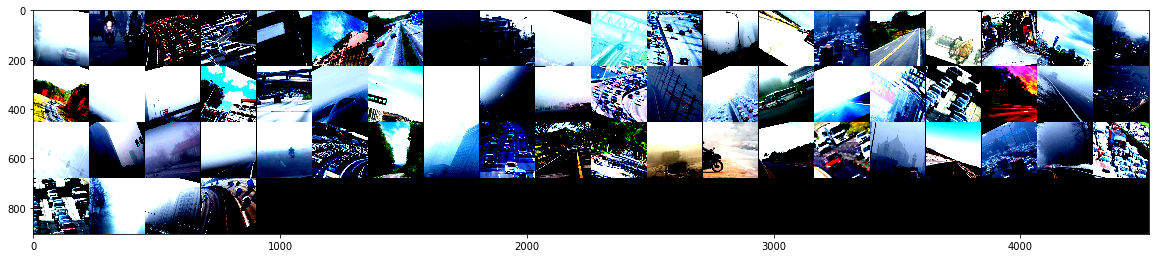

In [0]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

class_names = train_data.classes

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    



# Visualizing dataset (testing)

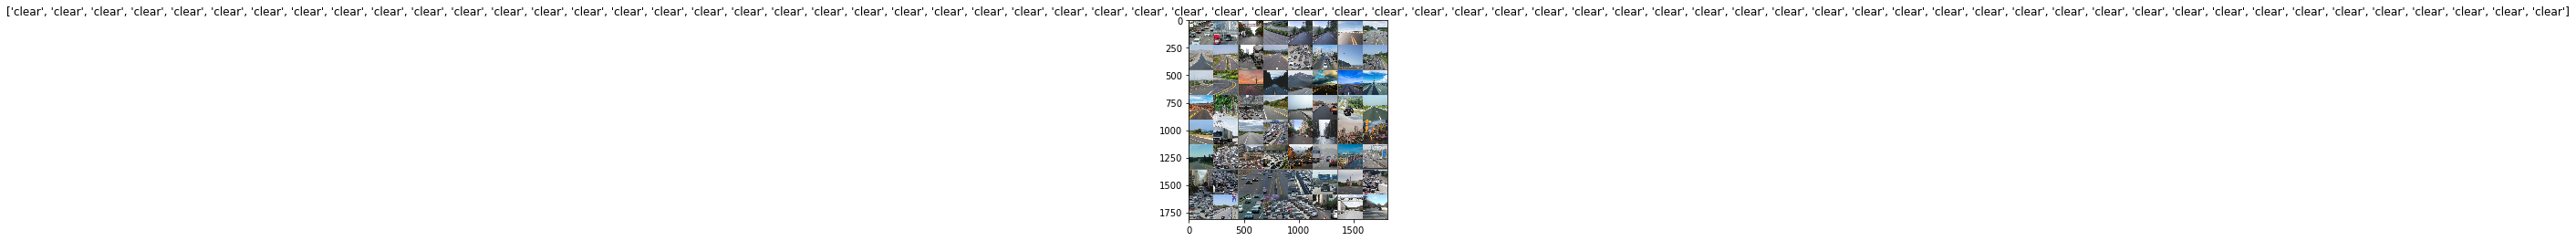

In [0]:
# Printing normalized images
images, labels = next(iter(testloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

# Checking if GPU enabled

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Defining model architechture , optimizers , loss function 

In [0]:
# defining device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# downloading model
model = models.resnet152(pretrained=True)  # if used inception , then use image size 299*299 otherwise 224*224 and use : model_ft.aux_logits=False to switch off auxiliary lyers
# setting firstly classifier only for training 
for param in model.parameters():
  param.requires_grad = False
  
# set inputs and output classes
num_ftrs = model.fc.in_features
out_ftrs = 2
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
# defining the loss function 
criterion = nn.NLLLoss()
  
# defining the optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.fc.parameters()) , lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# sending the model to device - GPU OR CPU
model.to(device);


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:06<00:00, 38043575.87it/s]


# Training and validation pass loop

In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses = [] , []
    valid_loss_min = np.Inf 
    model.train()
    print("Training started...")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      scheduler.step()
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
          print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader)))
        valid_loss_min = test_loss/len(validloader)
    print("Training completed")    
    return train_losses, test_losses
          

In [0]:
train_losses, test_losses = train_and_test(10)

Training started...
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
Epoch: 1/10..  Training Loss: 0.226..  Valid Loss: 0.089..  Valid Accuracy: 0.967
Validation loss decreased (inf --> 0.088812).  Saving model ...
 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
Epoch: 2/10..  Training Loss: 0.105..  Valid Loss: 0.131..  Valid Accuracy: 0.952
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
Epoch: 3/10..  Training Loss: 0.141..  Valid Loss: 0.081..  Valid Accuracy: 0.966
Validation loss decreased (0.088812 --> 0.081155).  Saving model ...
 epoch 4 batch 10 completed
 epoch 4 batch 20 completed
 epoch 4 batch 30 completed
 epoch 4 batch 40 completed
Epoch: 4/10..  Training Loss: 0.104..  Valid Loss: 0.068..  Valid Accuracy: 0.972
Validation loss decreased (0.081155 --> 0.068196).  Saving model ...
 e

# Plotting losses

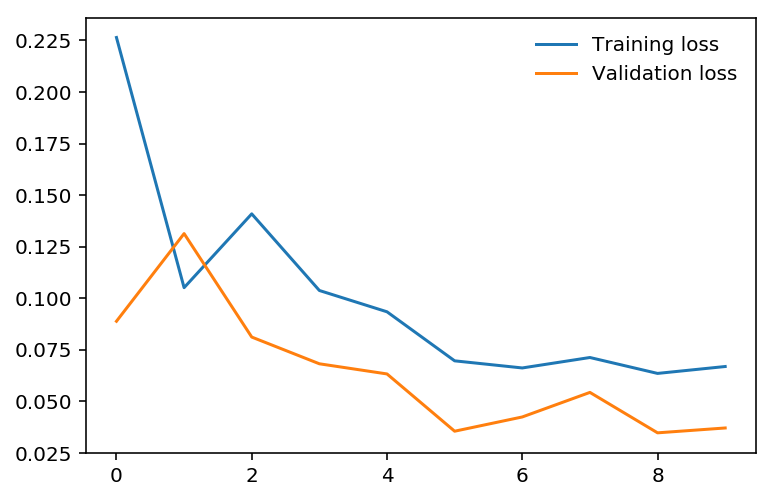

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Testing the model on unseen data

In [0]:
accuracy = 0
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        temp_acc = torch.sum(preds == labels.data)
        accuracy += temp_acc
        p_labels.append(preds)
    # getting ids of file images    
    for dir in os.listdir(test_dir):
        for file in os.listdir(os.path.join(test_dir, dir)):
            img_id = os.path.splitext(file)[0]
            img_ids.append(img_id)
    print('Accuracy On Test Data =====>>', (accuracy.item()/len(test_data)*100))

Accuracy On Test Data =====>> 98.25


# Using Helper.py for visualizing prediction on single image 
#### (credits: shudipto trafder for Helper.py)

In [0]:
# credits for Helper to Shudipto Trafder
!wget https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
import Helper

--2019-08-08 16:14:39--  https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21412 (21K) [text/plain]
Saving to: ‘Helper.py’

Helper.py           100%[===================>]  20.91K  --.-KB/s    in 0.005s  

2019-08-08 16:14:39 (3.91 MB/s) - ‘Helper.py’ saved [21412/21412]



Real Label:  clear
Path:  ../input/smog4000/Smog4000/test/clear/clear.280.jpg
Value: 0
clear


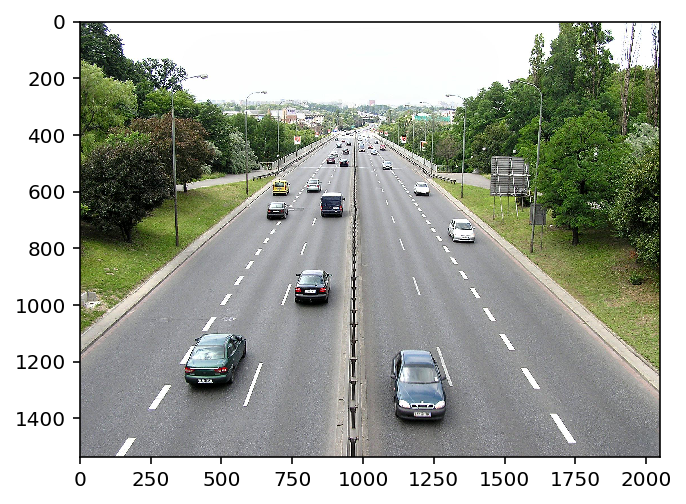

In [0]:
import random

# take random folder first
folders = os.listdir(test_dir)
num = random.randint(0, 1)
path = test_dir+"/"+folders[num]

# save label
label = folders[num]

# now take random file
files = os.listdir(path)
num = random.randint(0, len(files)-1)
name = path + "/" + files[num]

print("Real Label: ", label)
print('Path: ', name)

# Now pass this to model
Helper.test_with_single_image(model, name, test_transforms, class_names)

In [0]:
pred_labels = []
for l in p_labels:
    for l1 in l:
        pred_labels.append(l1.item())

In [0]:
output = pd.DataFrame({'Id': img_ids,'Predicted': pred_labels})

In [0]:
output

,Id,Predicted
0,clear.909,0
1,clear.358,0
2,clear.1357,0
3,clear.1669,0
4,clear.771,0
5,clear.741,0
6,clear.846,0
7,clear.1599,0
8,clear.1544,0
9,clear.839,0


In [0]:
output.to_csv('output.csv', index=False)